<a href="https://colab.research.google.com/github/goyalgitesh/CS240-ISCXVPN2016/blob/main/ISCX_VPN_NON_VPN_ML_MODEL_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import requests
import os
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Download dataset from kaggle

In [8]:
!kaggle datasets download -d jiecdeng/240iscx

Dataset URL: https://www.kaggle.com/datasets/jiecdeng/240iscx
License(s): unknown
240iscx.zip: Skipping, found more recently modified local copy (use --force to force download)


## Extract the zip file

In [9]:
zip_file_path = '/content/240iscx.zip'
destination_folder = '/content/'

In [10]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall(destination_folder)

## load dataset into pandas dataframe

In [11]:
data_df = pd.read_csv('/content/data.csv')
skype_df = pd.read_csv('/content/Skype.csv')
facebook_df = pd.read_csv('/content/facebook.csv')
hangouts_df = pd.read_csv('/content/Hangouts.csv')

In [12]:
data_df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Idle Mean,Idle Std,Idle Max,Idle Min,Label,flow_start,FirstNPkt_size,Category,App_protocol,Web_service
0,131.202.242.93-224.0.0.252-61387-5355-17,131.202.242.93,61387,224.0.0.252,5355,17,14/04/2015 09:02:23 AM,411508,2,0,...,0.0,0.0,0.0,0.0,facebook_audio,1429027166981,256,5,154,unknown
1,131.202.240.185-224.0.0.252-61903-5355-17,131.202.240.185,61903,224.0.0.252,5355,17,14/04/2015 09:50:59 AM,409461,2,0,...,0.0,0.0,0.0,0.0,facebook_audio,1429029490112,320,5,154,unknown
2,131.202.243.49-224.0.0.252-54386-5355-17,131.202.243.49,54386,224.0.0.252,5355,17,14/04/2015 09:26:11 AM,420654,2,0,...,0.0,0.0,0.0,0.0,facebook_audio,1429028771578,256,5,154,unknown
3,131.202.240.90-224.0.0.252-62986-5355-17,131.202.240.90,62986,224.0.0.252,5355,17,14/04/2015 10:03:16 AM,411687,2,0,...,0.0,0.0,0.0,0.0,facebook_audio,1429030996631,128,5,154,unknown
4,131.202.243.9-224.0.0.252-65036-5355-17,131.202.243.9,65036,224.0.0.252,5355,17,14/04/2015 09:14:50 AM,411041,2,0,...,0.0,0.0,0.0,0.0,facebook_audio,1429028090866,128,5,154,unknown


## Dataset Summary

In [13]:
dataframes = [data_df, skype_df, facebook_df, hangouts_df]
for df in dataframes:
  print(df.info(), "\n")
  print(df.describe(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135514 entries, 0 to 135513
Data columns (total 89 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Flow ID            135514 non-null  object 
 1   Src IP             135514 non-null  object 
 2   Src Port           135514 non-null  int64  
 3   Dst IP             135514 non-null  object 
 4   Dst Port           135514 non-null  int64  
 5   Protocol           135514 non-null  int64  
 6   Timestamp          135514 non-null  object 
 7   Flow Duration      135514 non-null  int64  
 8   Tot Fwd Pkts       135514 non-null  int64  
 9   Tot Bwd Pkts       135514 non-null  int64  
 10  TotLen Fwd Pkts    135514 non-null  float64
 11  TotLen Bwd Pkts    135514 non-null  float64
 12  Fwd Pkt Len Max    135514 non-null  float64
 13  Fwd Pkt Len Min    135514 non-null  float64
 14  Fwd Pkt Len Mean   135514 non-null  float64
 15  Fwd Pkt Len Std    135514 non-null  float64
 16  Bw

## Data Cleaning and Optimizations

In [14]:
# Add a source column to each dataframe
data_df['source'] = 'data'
skype_df['source'] = 'skype'
facebook_df['source'] = 'facebook'
hangouts_df['source'] = 'hangouts'

In [15]:
# Combine all dataframes into a single dataframe
combined_df = pd.concat([data_df, skype_df, facebook_df, hangouts_df])

In [16]:
print(combined_df.columns)

Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE 

## Defining Features and Target

In [17]:
# Define features and target
features = combined_df.drop(columns=['Label', 'source', 'Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'flow_start', 'Category', 'App_protocol', 'Web_service'])
target = combined_df['Label']

In [18]:
# Replace infinite values with NaN and NAN values with 0
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.replace(np.nan,0,inplace=True)

# Check for any remaining NaN values
print(features.isna().sum())

Src Port          0
Dst Port          0
Protocol          0
Flow Duration     0
Tot Fwd Pkts      0
                 ..
Idle Mean         0
Idle Std          0
Idle Max          0
Idle Min          0
FirstNPkt_size    0
Length: 80, dtype: int64


## Split the dataset into training, testing

In [19]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)


# Train the model 1 -> LogisticRegression()

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

facebook_audio       0.41      0.92      0.57     30918
 facebook_chat       0.00      0.00      0.00       316
facebook_video       0.00      0.00      0.00       324
 hangout_audio       0.48      0.18      0.26     31285
  hangout_chat       0.00      0.00      0.00       278
 hangout_video       0.00      0.00      0.00      1044
   skype_audio       0.00      0.00      0.00     12988
    skype_chat       0.00      0.00      0.00      2629
   skype_video       0.00      0.00      0.00       356
       unknown       0.00      0.00      0.00      1171

      accuracy                           0.42     81309
     macro avg       0.09      0.11      0.08     81309
  weighted avg       0.34      0.42      0.32     81309

[[28486     0     0  2432     0     0     0     0     0     0]
 [  207     0     0   109     0     0     0     0     0     0]
 [   57     0     0   267     0     0     0     0     0     0]
 [25682     0     0  560

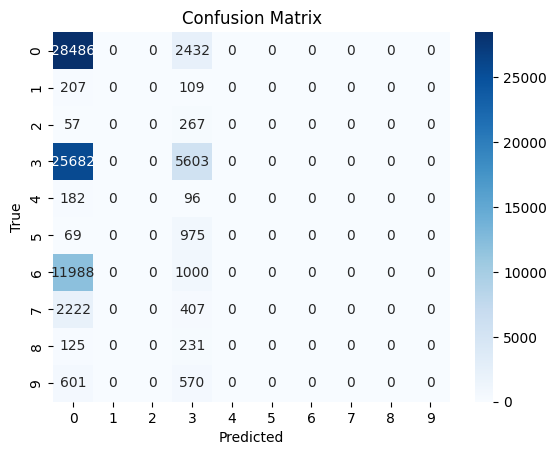

In [21]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


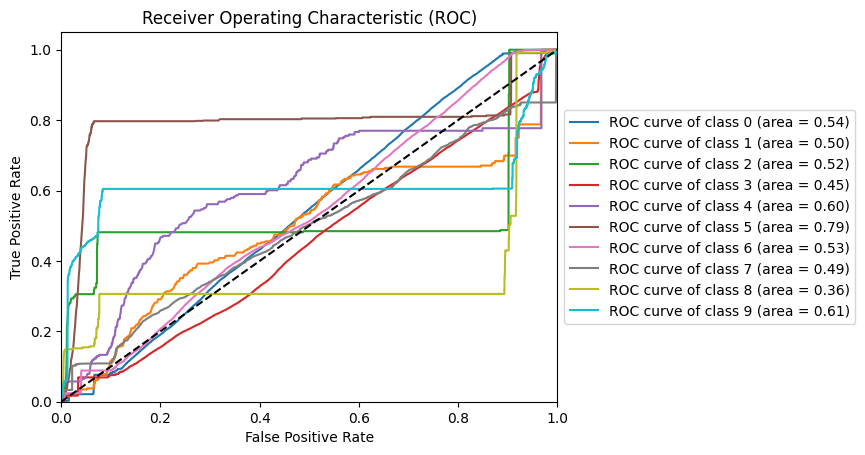

In [22]:
## Plotting ROC Curves for Each Class (One-vs-Rest):

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


class_labels = sorted(y_train.unique())


# Binarize the output
y_bin = label_binarize(y_test, classes=class_labels)  # Replace `class_labels` with the list of class labels

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_labels)):  # Loop over the number of classes
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

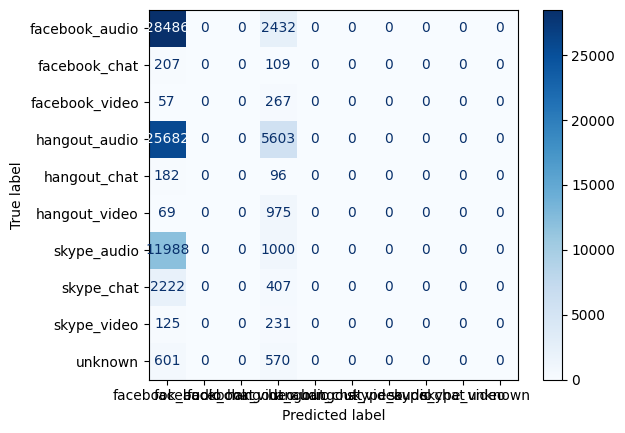

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


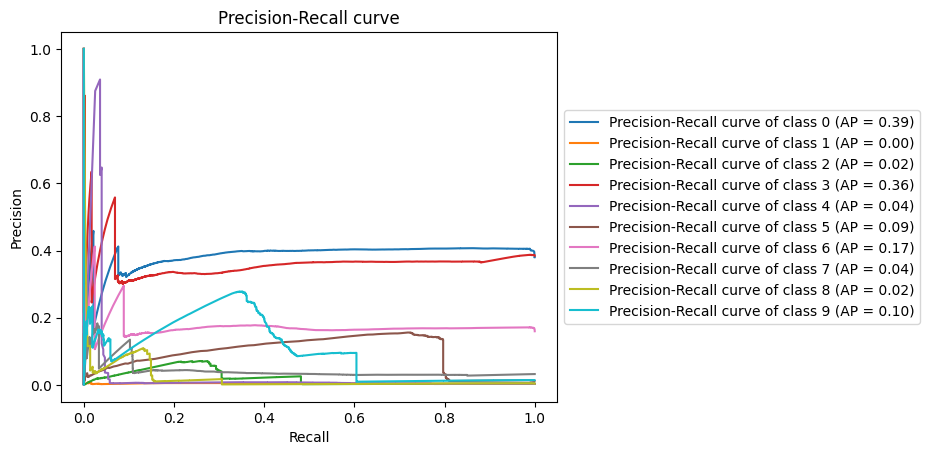

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall pairs for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(class_labels)):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], model.predict_proba(X_test)[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], model.predict_proba(X_test)[:, i])

# Plot Precision-Recall curve
plt.figure()
for i in range(len(class_labels)):
    plt.plot(recall[i], precision[i], label=f'Precision-Recall curve of class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


In [25]:
from sklearn.metrics import accuracy_score

# Assuming you have already split your data and trained your model
# y_test is the true labels and y_pred are the predicted labels from the model

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.42


# Train the model 2 -> RandomForest()

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_y_pred = rf_model.predict(X_test)

In [27]:
# Calculate accuracy
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f'Random Forest Accuracy: {rf_accuracy:.2f}')

Random Forest Accuracy: 0.84


# Train the model 3 -> SGD Classifier (SGD)

In [28]:
from sklearn.linear_model import SGDClassifier

# Initialize and train the SGDClassifier with hinge loss
sgd_model = SGDClassifier(loss='hinge', random_state=42)
sgd_model.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [29]:
# Calculate accuracy
sgd_y_pred = sgd_model.predict(X_test)
sgd_accuracy = accuracy_score(y_test, sgd_y_pred)
print(f'SGD Accuracy: {sgd_accuracy:.2f}')

SGD Accuracy: 0.34


# Train the model 4 -> Gradient Boosting Classifier


In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

In [31]:
# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Calculate accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {accuracy_gb:.2f}")

Gradient Boosting Accuracy: 0.51


# Compare Accuracies and Errors

In [34]:
# prompt: generate code for filling all these above lists for all models

models = ['Logistic Regression', 'RandomForest', 'SGD Classifier', 'GraidentBoosting']
accuracies = [accuracy, rf_accuracy, sgd_accuracy, accuracy_gb]
errors = [1 - acc for acc in accuracies]

# Calculate recall, precision, and F1-score for each model
reports = [
    classification_report(y_test, y_pred, output_dict=True),
    classification_report(y_test, rf_y_pred, output_dict=True),
    classification_report(y_test, sgd_y_pred, output_dict=True),
    classification_report(y_test, y_pred_gb, output_dict=True)
]

recall = [report['macro avg']['recall'] for report in reports]
precision = [report['macro avg']['precision'] for report in reports]
f1_score = [report['macro avg']['f1-score'] for report in reports]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

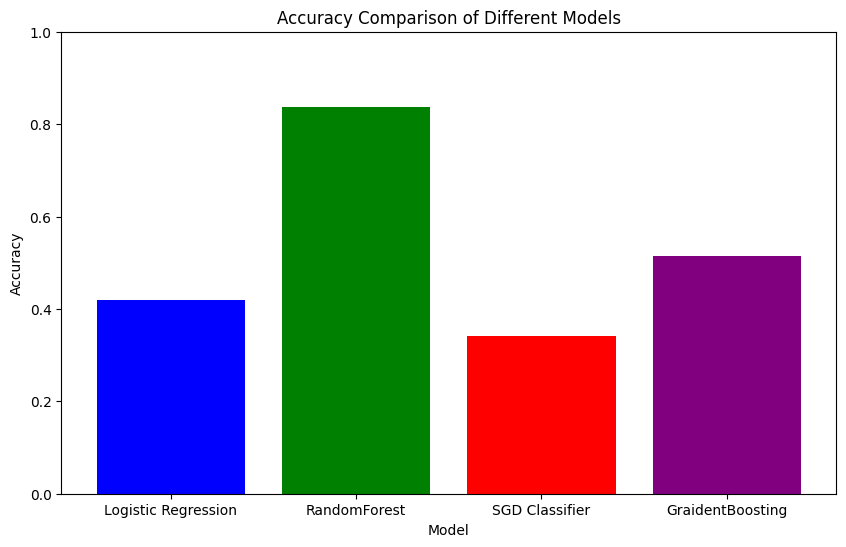

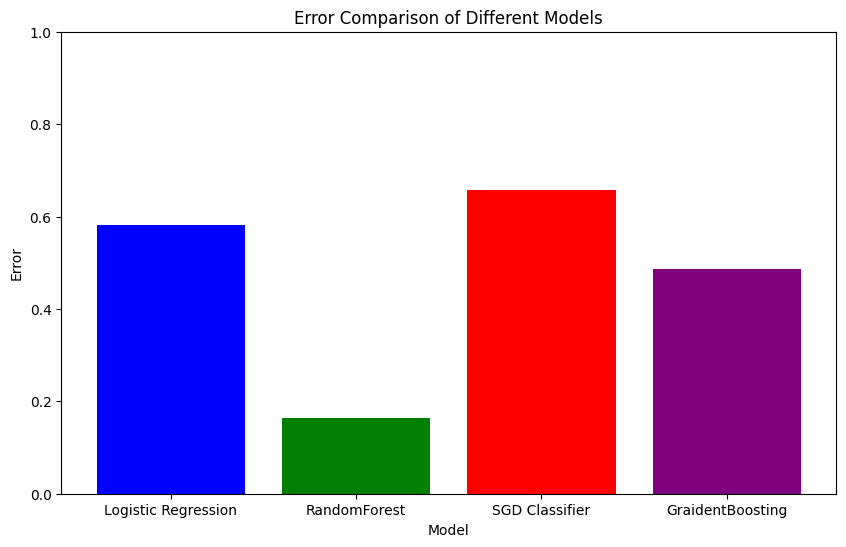

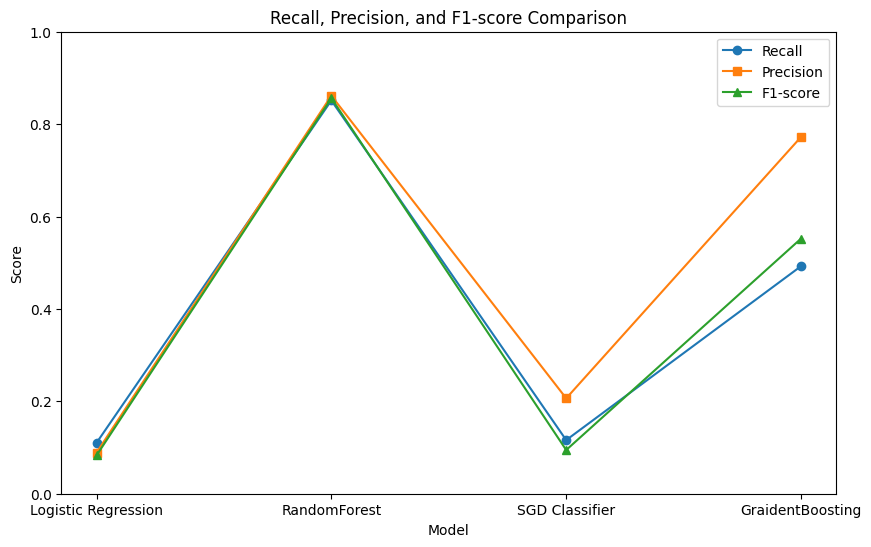

In [35]:
# prompt: draw plots for different metrics comparisons

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim([0, 1])
plt.show()

# Plot errors
plt.figure(figsize=(10, 6))
plt.bar(models, errors, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Error')
plt.title('Error Comparison of Different Models')
plt.ylim([0, 1])
plt.show()

# Plot recall, precision, and F1-score
plt.figure(figsize=(10, 6))
plt.plot(models, recall, label='Recall', marker='o')
plt.plot(models, precision, label='Precision', marker='s')
plt.plot(models, f1_score, label='F1-score', marker='^')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Recall, Precision, and F1-score Comparison')
plt.legend()
plt.ylim([0, 1])
plt.show()


<ipython-input-42-152de6f5cd9f>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  disp.plot(cmap=plt.cm.get_cmap(color))


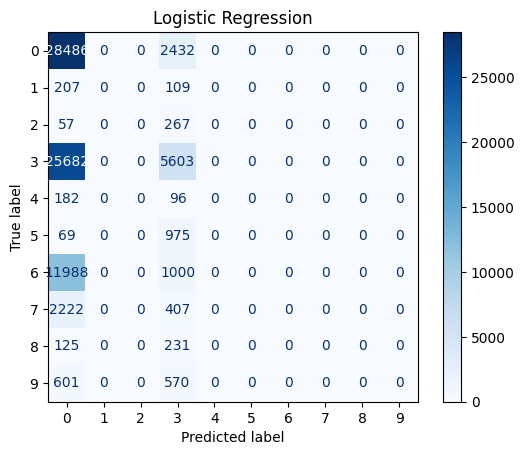

<ipython-input-42-152de6f5cd9f>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  disp.plot(cmap=plt.cm.get_cmap(color))


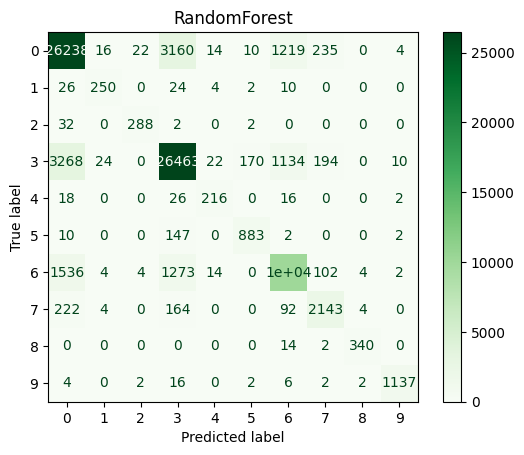

<ipython-input-42-152de6f5cd9f>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  disp.plot(cmap=plt.cm.get_cmap(color))


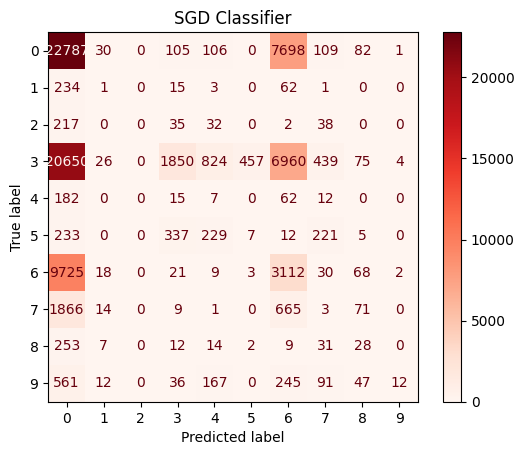

<ipython-input-42-152de6f5cd9f>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  disp.plot(cmap=plt.cm.get_cmap(color))


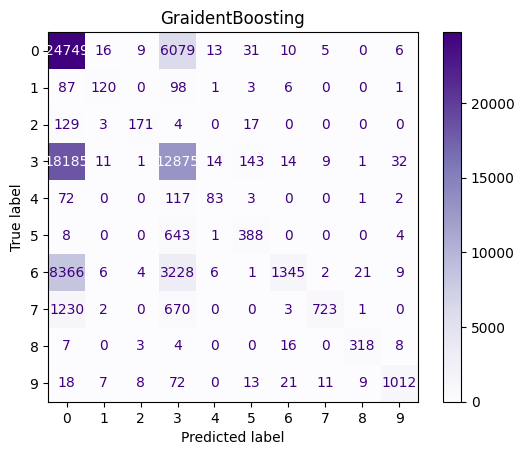

In [42]:
# prompt: generate code for confusion matrix for all models . Please make sure predicted labels and true label text not overlapping on each other. Also use different colors confusion matrix

# Assuming you have already trained your models and have y_test, y_pred, rf_y_pred, sgd_y_pred, y_pred_gb

models = ['Logistic Regression', 'RandomForest', 'SGD Classifier', 'GraidentBoosting']
predictions = [y_pred,rf_y_pred,sgd_y_pred,y_pred_gb]
colors = ['Blues', 'Greens', 'Reds', 'Purples']

for i, (model, preds, color) in enumerate(zip(models, predictions, colors)):
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.get_cmap(color))
    plt.title(model)
    plt.show()


